In [1]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')
    !pip install torchaudio
    !pip install wandb --upgrade
    # !wandb login
    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews
    !pip install -U ipykernel
    !pip install joypy
    # !pip install umap-learn
    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
#     #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
#     #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
#     sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
#     sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
#     sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
#     sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Results')
#     sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Figures')
#     sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Result')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics/Jaguas"
    root_path = "media/mirp_ai/Seagate Desktop Drive/Jaguas_2018"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from six.moves import xrange
import datetime
import gc
import pandas as pd
import joypy

from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchaudio.transforms as audio_transform


#from ResidualStack import ResidualStack
#from Residual import Residual

from Jaguas_DataLoader_rainless import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()

from datetime import timedelta
import wandb
from wandb import AlertLevel

!pip install umap-learn
!pip install umap-learn[plot]
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns
import pickle as pkl

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


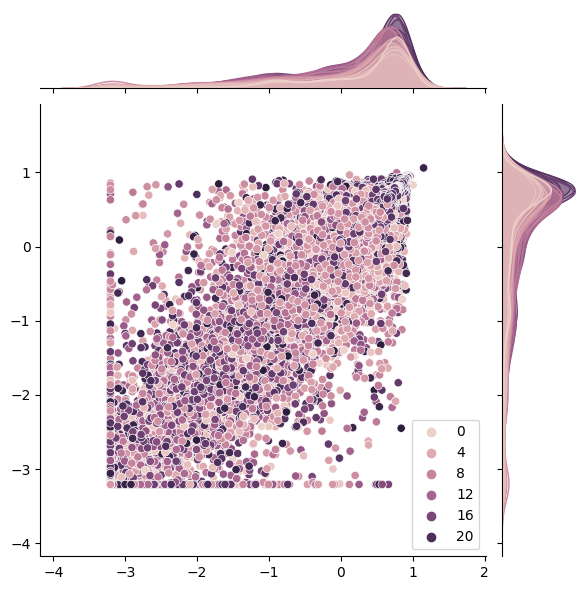

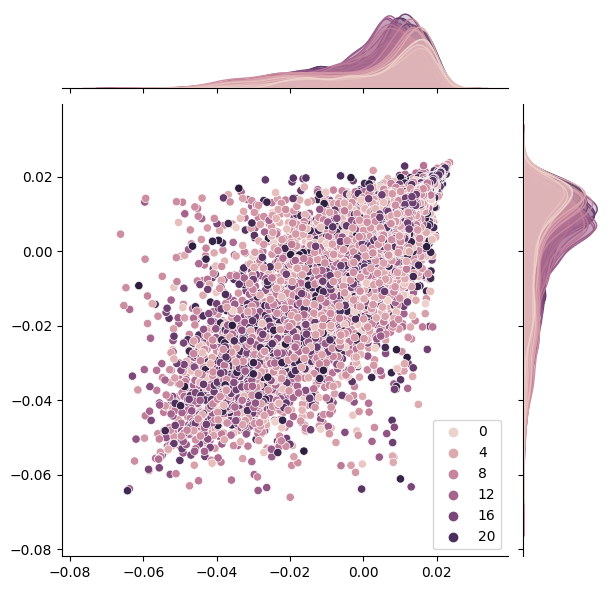

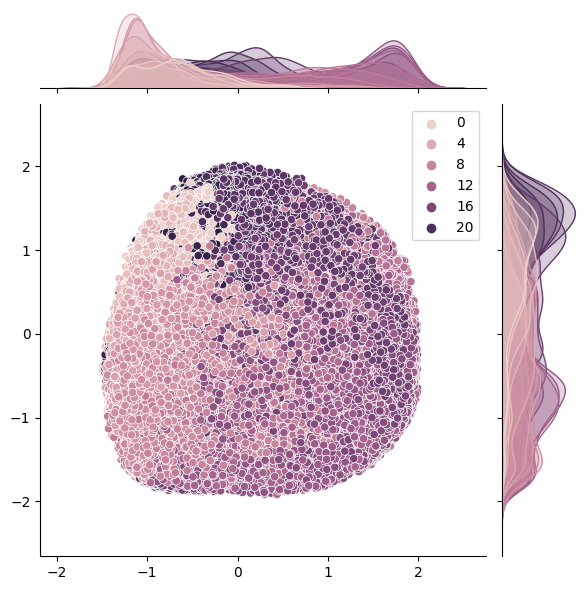

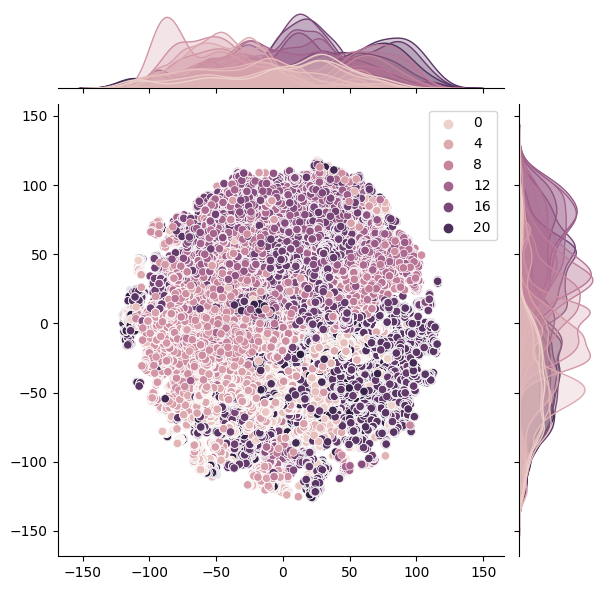

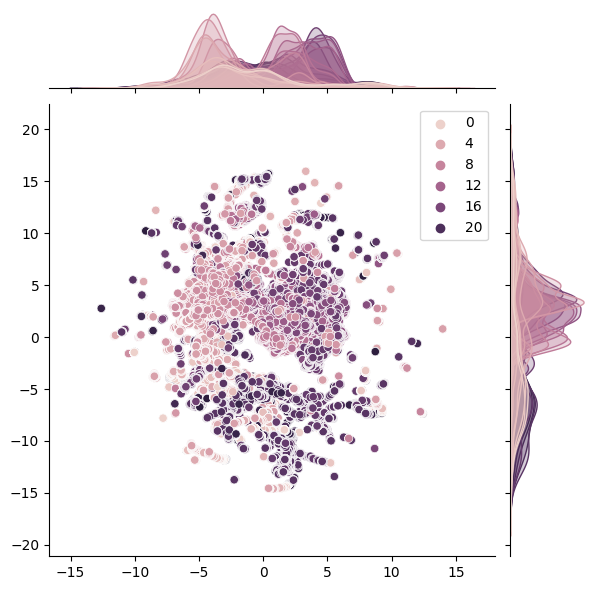

In [3]:
model = "AE"
identifier = "batch_size_14_num_hiddens_64_"
day = 27
hour = 19
month = 6
date_format = f"day_{day}_hour_{hour}"
folder = f"{model}_No_rain"
labels_rainless = torch.load(f"temporal/Features/{folder}/{model}_labels_{date_format}_No_rain_Audios_Jaguas.pth",  map_location=torch.device('cpu'))
data_rainless = torch.load(f"temporal/Features/{folder}/{model}_features_{date_format}_No_rain_Audios_Jaguas.pth",  map_location=torch.device('cpu'))
# labels_rain = torch.load("temporal/features/")
# data_rain = torch.load("temporal/features/")

X_n = data_rainless.numpy()
#Standard Scaler
scaler = StandardScaler().fit(X_n)
X_scaled = scaler.transform(X_n)
#Normalizing
X_norm = Normalizer().fit_transform(X_scaled)
#PCA
n_components = 80
X_PCA = PCA(n_components=n_components).fit_transform(X_norm)
X_PCA = StandardScaler().fit_transform(X_PCA)
X_PCA = Normalizer().fit_transform(X_PCA)
#TSNE
X_TSNE = TSNE(n_components=2, learning_rate="auto", init='random', random_state=0).fit_transform(X_PCA)
X_TSNE_Norm = Normalizer().fit_transform(X_TSNE)

#UMAP
reducer = umap.UMAP()
X_UMAP = reducer.fit_transform(X_PCA)
X_UMAP_Norm = Normalizer().fit_transform(X_UMAP)

metadata = "hour"
y_n = labels_rainless[metadata].numpy()

X_ = [X_scaled, X_norm, X_PCA, X_TSNE, X_UMAP]
Feats = ["Scaled", X_norm, f"PCA{n_components}", "TSNE", "UMAP"]
for enum, x in enumerate(X_):
    sns.jointplot(x=X_[enum][:,0], y= X_[enum][:,1], hue=y_n, joint_kws={'alpha': 0.03}) 
    plt.savefig(f"Projection_{model}_{Feats[enum]}_{metadata}_alpha_03")

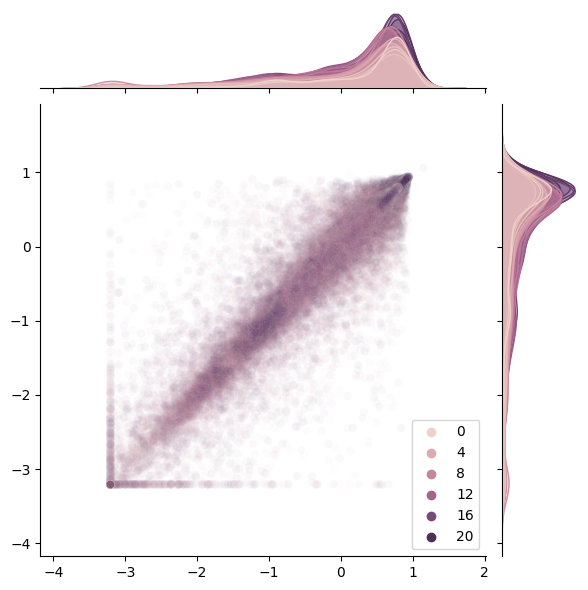

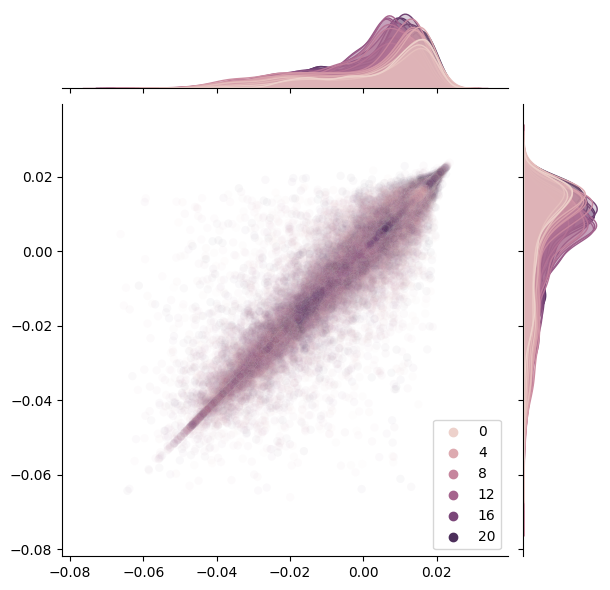

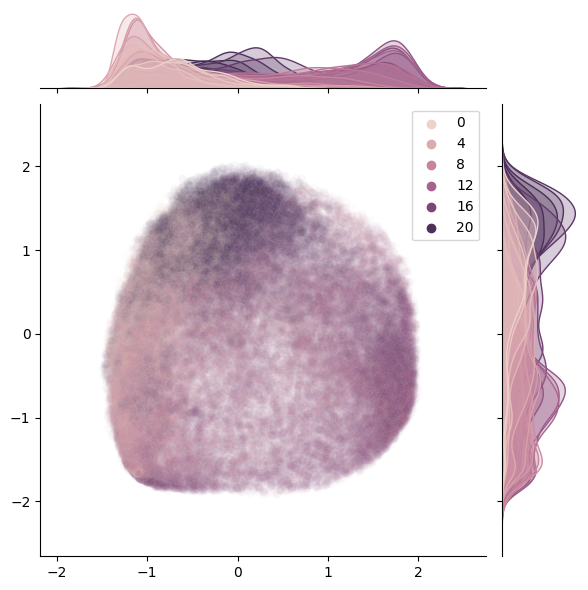

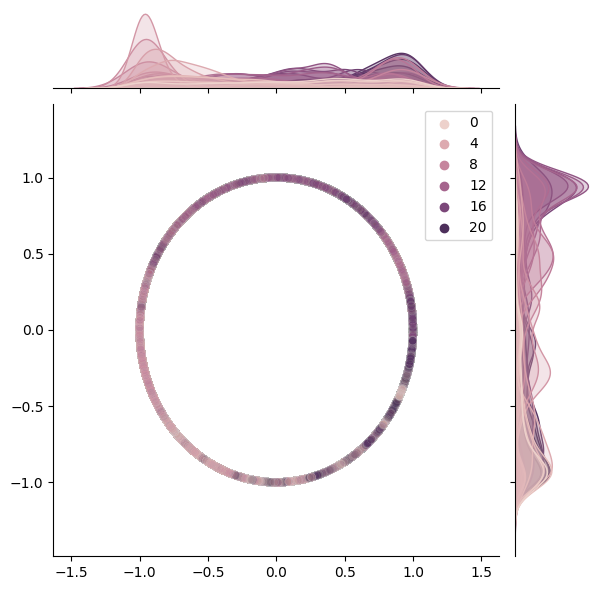

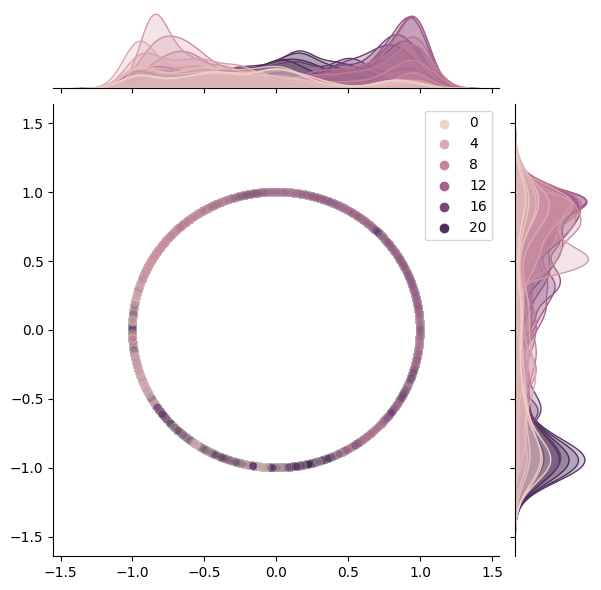

In [26]:
metadata = "hour"
y_n = labels_rainless[metadata].numpy()
X_ = [X_scaled, X_norm, X_PCA, X_TSNE_Norm, X_UMAP_Norm]
for enum, x in enumerate(X_):
    sns.jointplot(x=X_[enum][:,0], y= X_[enum][:,1], hue=y_n, joint_kws={'alpha': 0.03}) 

In [33]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(X_PCA);
    u = Normalizer().fit_transform(u)
    print(np.max(u), u.shape)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=y_n)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=y_n)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=y_n, s=100)
    plt.title(title, fontsize=18)

for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

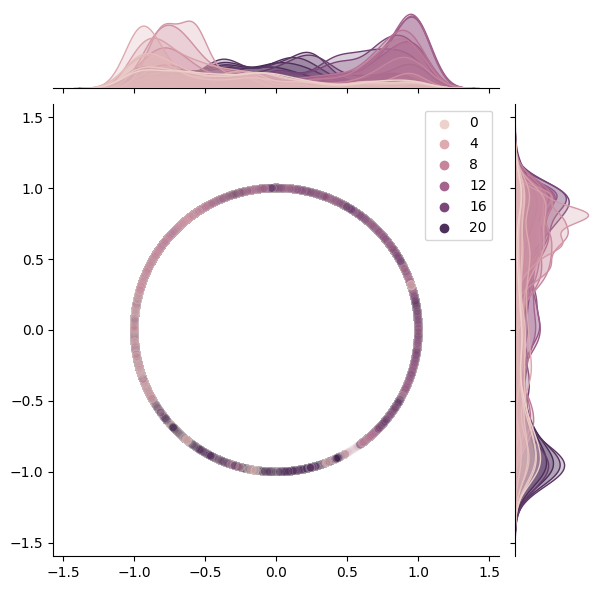

In [38]:
sns.jointplot(x=X_[:,0], y= X_[:,1], hue=y_n, joint_kws={'alpha': 0.03}) 

In [ ]:
reducer = umap.UMAP(n_neighbors=200)
X_UMAP = reducer.fit_transform(X_PCA)
X_ = Normalizer().fit_transform(X_UMAP)
sns.jointplot(x=X_[:,0], y= X_[:,1], hue=y_n, joint_kws={'alpha': 0.03}) 

## PCA

In [ ]:
n_components = 80
X_PCA_ = PCA(n_components=n_components).fit(X_scaled)
X_PCA = X_PCA_.transform(X_scaled)
plt.figure(figsize=(10,8))
plt.plot(range(0, n_components), X_PCA_.explained_variance_ratio_.cumsum())
plt.title("Explained variance by components")
plt.xlabel("Number of components")
plt.ylabel("Cummulative Explained Variance ")
plt.axhline(y=0.9, c="r", linestyle="--")

## TSNE

In [ ]:
X_TSNE = TSNE(n_components=2, learning_rate="auto", init='random', random_state=0).fit_transform(X_scaled)

In [ ]:
a= np.arange(X_TSNE.shape[0])
a = np.random.choice(a, size=84820)
new_embedding = X_TSNE[a]
y_n2 = y_n[a]

plt.scatter(
    new_embedding[:, 0],
    new_embedding[:, 1], c=y_n2)
plt.gca().set_aspect('equal', 'datalim')
plt.title('TSNE projection of Jaguas dataset', fontsize=24);

In [ ]:
new_embedding.shape

## UMAP

In [ ]:
X_UMAP = reducer.fit_transform(X_PCA)

In [ ]:
a= np.arange(X_UMAP.shape[0])
a = np.random.choice(a, size=84820)
new_embedding = X_UMAP[a]
y_n2 = y_n[a]

plt.scatter(
    new_embedding[:, 0],
    new_embedding[:, 1], c=y_n2)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of Jaguas dataset', fontsize=24);
